### **Creating ML Models to Predict Sequences**

**How to use ML for forecasting?** 

But before start creating models $\rightarrow$ need to **understand how to structure the time series data for training predictive models**, by creating **`a windowed dataset`**

<center>

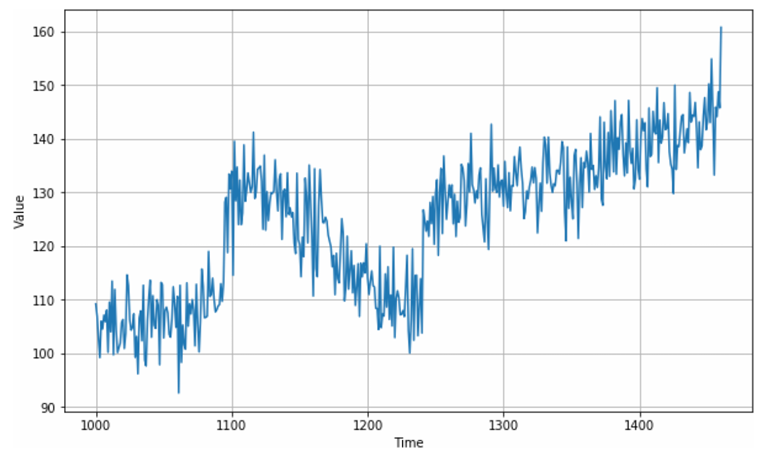

<caption>Synthetic time series</caption>

</center>

At any point predict a value at time $t$ $\rightarrow$ want to predict it **as a function of the values preceding time $t$**. 

For example, **predict the value** of the time series **at time step 1200** *as a function of the 30 values preceding it* 

$\Rightarrow$ In this case, **the values from time steps** **1170 to 1199** would **determine** *the value at time step 1,200*

<center>

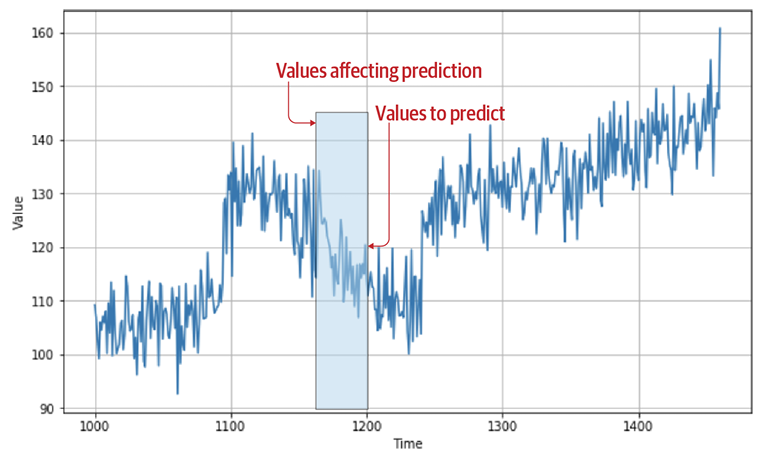

<caption>Previous values impacting prediction</caption>

</center>

Consider the values from **1170–1199** to be **the `features`** and **the value at 1200** to be **the `label`**. 

If **get the dataset into a condition** where having **a certain number of values as `features`** and **the following one as the `label`** $\rightarrow$ do this for every known value in the dataset $\rightarrow$ end up with a pretty decent **set of features and labels** $\rightarrow$ **used to train a model**. 


Create **a very simple dataset** that has **all attributes** but with **a much smaller amount of data**.

### **Creating a Windowed Dataset**

In [165]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras_tuner import HyperParameters, RandomSearch

The **`tf.data`** libraries contain **a lot of APIs** $\rightarrow$ are useful for **manipulating data**. 

Create a basic dataset containing **the numbers 0–9**, **emulating a time series** $\rightarrow$ then turn that into **the beginnings of a windowed dataset**

In [112]:
dataset = tf.data.Dataset.range(10) # 0 to 9

dataset = dataset.window(5, shift=1, drop_remainder=True) # 0 to 4, 1 to 5, 2 to 6, 3 to 7, 4 to 8, 5 to 9

dataset = dataset.flat_map(lambda window: window.batch(5)) # mapped to 0 to 4, 1 to 5, 2 to 6, 3 to 7, 4 to 8, 5 to 9

for window in dataset:
    print(window, "|" , window.numpy())


tf.Tensor([0 1 2 3 4], shape=(5,), dtype=int64) | [0 1 2 3 4]
tf.Tensor([1 2 3 4 5], shape=(5,), dtype=int64) | [1 2 3 4 5]
tf.Tensor([2 3 4 5 6], shape=(5,), dtype=int64) | [2 3 4 5 6]
tf.Tensor([3 4 5 6 7], shape=(5,), dtype=int64) | [3 4 5 6 7]
tf.Tensor([4 5 6 7 8], shape=(5,), dtype=int64) | [4 5 6 7 8]
tf.Tensor([5 6 7 8 9], shape=(5,), dtype=int64) | [5 6 7 8 9]


**First** creating **the dataset using a range** $\rightarrow$ makes the dataset contain the **values `0` to `n – 1`**

**Next** calling **`dataset.window`** 

_ Passing a parameter of **`5`** $\rightarrow$ to **split** the dataset into **windows of five items**

_ Specifying **`shift=1`** $\rightarrow$ **each window** to then be **shifted one spot** from **the previous one** - the first window will contain the five items beginning at 0, the next window the five items beginning at 1, etc. 

_ Setting **`drop_remainder to True`**  $\rightarrow$ specifies that once it reaches the point close to the end of the dataset where the windows would be smaller than the desired size of five, they should be dropped.

**drop_remainder=True**

```Python

tf.Tensor([0 1 2 3 4], shape=(5,), dtype=int64) | [0 1 2 3 4]
tf.Tensor([1 2 3 4 5], shape=(5,), dtype=int64) | [1 2 3 4 5]
tf.Tensor([2 3 4 5 6], shape=(5,), dtype=int64) | [2 3 4 5 6]
tf.Tensor([3 4 5 6 7], shape=(5,), dtype=int64) | [3 4 5 6 7]
tf.Tensor([4 5 6 7 8], shape=(5,), dtype=int64) | [4 5 6 7 8]
tf.Tensor([5 6 7 8 9], shape=(5,), dtype=int64) | [5 6 7 8 9]

```


**drop_remainder=False**

```Python

tf.Tensor([0 1 2 3 4], shape=(5,), dtype=int64) | [0 1 2 3 4]
tf.Tensor([1 2 3 4 5], shape=(5,), dtype=int64) | [1 2 3 4 5]
tf.Tensor([2 3 4 5 6], shape=(5,), dtype=int64) | [2 3 4 5 6]
tf.Tensor([3 4 5 6 7], shape=(5,), dtype=int64) | [3 4 5 6 7]
tf.Tensor([4 5 6 7 8], shape=(5,), dtype=int64) | [4 5 6 7 8]
tf.Tensor([5 6 7 8 9], shape=(5,), dtype=int64) | [5 6 7 8 9]
tf.Tensor([6 7 8 9], shape=(4,), dtype=int64) | [6 7 8 9]
tf.Tensor([7 8 9], shape=(3,), dtype=int64) | [7 8 9]
tf.Tensor([8 9], shape=(2,), dtype=int64) | [8 9]
tf.Tensor([9], shape=(1,), dtype=int64) | [9]

```


Given **the window definition**, the process of **splitting** the dataset can take place $\rightarrow$ do with the **`flat_map`** function.

Make training data out of this, where there are **`n` values** defining a **feature** and **a `subsequent` value** giving a **label** $\rightarrow$ do by adding **another lambda function** that **splits each window into everything before the last value** and then the last value.

In [113]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

for x,y in dataset:
    print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


The **first four values** in the window can be the **features**, with **the subsequent value** being the **label**.

It supports **shuffling** and **batching** via lambda functions too.

In [114]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)

dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

dataset = dataset.shuffle(buffer_size=10)

for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())

x =  [4 5 6 7]
y =  [8]
x =  [3 4 5 6]
y =  [7]
x =  [0 1 2 3]
y =  [4]
x =  [2 3 4 5]
y =  [6]
x =  [1 2 3 4]
y =  [5]
x =  [5 6 7 8]
y =  [9]


In [115]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)

dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1) # Groups data into batches of size 2 and ensures that 1 batch is always prepared in advance

for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())

x =  [[5 6 7 8]
 [2 3 4 5]]
y =  [[9]
 [6]]
x =  [[3 4 5 6]
 [0 1 2 3]]
y =  [[7]
 [4]]
x =  [[1 2 3 4]
 [4 5 6 7]]
y =  [[5]
 [8]]


Now turn any time series dataset into **a set of training data for a neural network**. From there, **creating a simple DNN** that **is trained on this data** and used to **predict future values**.

***Understanding prefetch(1) in TensorFlow Data Pipelines***

In TensorFlow, **`.prefetch(buffer_size=1)`** is used to **optimize data loading** during training.

***What does `prefetch(1)` do?***
- Allows **overlapping** of **data preprocessing** and **model training**.
- While **the GPU/TPU** is training on one batch, **the CPU** loads the **next batch** into memory.
- **`prefetch(1)`** means **prefetch 1 batch at a time**, **keeping one batch ready in the pipeline**.

***Why is it useful?***
- **Reduces training time** by ensuring that the mode l**never waits for data**.
- **Improves GPU utilization** by keeping the training process smooth.
- **Prevents bottlenecks** caused by slow data loading.

**When to use a larger `buffer_size`?**

- **data loading is slow** $\rightarrow$ **increase `buffer_size`**
- **`tf.data.AUTOTUNE`** automatically selects an optimal prefetch size

```Python

dataset = dataset.batch(2).prefetch(tf.data.AUTOTUNE)


```

### **Creating a Windowed Version of the Time Series Dataset**

In [116]:
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [117]:
time = np.arange(4 * 365 + 1, dtype="float32")
series = trend(time, 0.1)
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

In [118]:
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude) + noise(time, noise_level, seed=42)

Once **have the series** $\rightarrow$ turn it into **a windowed dataset**.

Use the **`from_tensor_slices`** method of **`tf.data.Dataset`**, which allows to **turn a series into a Dataset**.

In [119]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) # window_size + 1 because have to include the target value
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) # flat_map() instead of map() to flatten the windows into one large dataset
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset


To **get a training-ready dataset** $\rightarrow$ **split** the series into **training** and **validation datasets** $\rightarrow$ then specify details like **the size of the window**, **the batch size**, and **the shuffle buffer size**:

In [120]:
split_time = 1000
time_train = time[:split_time]
series_train = series[:split_time]
time_valid = time[split_time:]
series_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [121]:
dataset = windowed_dataset(series_train, window_size, batch_size, shuffle_buffer_size)

**The important thing** - The data is a **`tf.data.Dataset`** $\rightarrow$ easily be passed to **`model.fit`** as a single parameter and **`tf.keras`** will take care of the rest.

In [122]:
for window in dataset.take(1):
    print(window)

(<tf.Tensor: shape=(32, 20), dtype=float64, numpy=
array([[ 98.62211154, 104.6833801 , 100.87476717, 101.50935966,
        102.13908909, 101.59366823, 102.63381033, 106.13124391,
        100.53356257, 103.16165697,  99.23383953, 106.94918227,
         96.4329036 , 108.88604219,  99.74720829,  92.86097892,
        100.722416  ,  96.74386586, 104.41975522,  97.02101401],
       [ 25.887356  ,  33.31907747,  29.59038683,  18.89190677,
         29.15839897,  25.43957502,  23.80360144,  30.06611002,
         31.97861364,  31.29236404,  22.24875949,  24.70428526,
         27.70887224,  30.72928051,  23.25155542,  24.51197077,
         19.69847726,  19.03615018,  28.86407412,  31.36422512],
       [ 90.25487046,  92.49587392,  93.200129  ,  96.51046498,
         94.12648871,  86.38826539,  94.78920337,  95.76066188,
         95.32257285,  97.73987165,  96.31446246,  94.2462483 ,
         91.40173492,  83.24675478,  93.49552609,  92.17870485,
         92.28805471,  84.3334431 ,  85.09615925,  

In [123]:
for features, labels in dataset.take(1):
    print("F = ", features)
    print("L = ", labels)

F =  tf.Tensor(
[[101.87997983  91.81160766  97.78883926  94.02830106  96.18856207
  102.48728342  97.10101841  96.42854047  89.44821685 100.03024091
   99.57817469 107.21912091  94.91636243  97.60371673  97.80790017
  104.50156999  96.19144531  98.11695516  99.81554456  97.76361202]
 [ 75.51523679  77.42005132  67.41134676  69.30249177  79.84103055
   77.06040477  75.36759705  76.46119585  78.1885082   73.83345105
   72.72243664  96.67923085  90.89516919  97.90941258  87.43041847
  101.15838958  98.43895329  97.41357152 101.09842959 104.55802408]
 [ 55.53666539  63.19219302  65.10123954  73.45097318  66.76330661
   64.09330198  69.39621156  54.25413028  66.54873929  69.28608866
   58.1001718   71.27344246  67.30896     63.602073    68.90468539
   77.15672509  66.77531333  67.17001986  63.69527619  61.80623622]
 [ 54.71676384  44.29978672  53.94671471  47.62394995  57.24739534
   55.48362218  48.70179278  50.58147184  47.6035143   52.33422948
   57.17074258  47.21327269  54.40857257  4

In [124]:
for window in dataset:
    print(window)

(<tf.Tensor: shape=(32, 20), dtype=float64, numpy=
array([[ 28.28731408,  28.30386237,  31.86461368,  21.10488822,
         22.05741195,  27.87551876,  25.62202642,  32.25093942,
         26.12742876,  23.58823506,  37.95459043,  29.4684772 ,
         30.90046909,  23.39904998,  27.75537176,  30.9809664 ,
         24.61506538,  32.18686259,  27.23821967,  28.71073406],
       [ 78.42366235,  79.00886126,  82.39471971,  73.17344586,
         80.46759835,  79.15848632,  80.56140793,  79.32027101,
         89.92866134,  74.24373416,  74.56036252,  73.88527393,
         74.01204312,  73.39384439,  82.32020473,  83.27506763,
         73.11941306,  71.6152073 ,  77.94125289,  72.63366017],
       [ 61.27206176,  68.27648587,  60.41106525,  67.52481218,
         57.74896863,  66.09798787,  70.7085946 ,  51.1946225 ,
         59.62077503,  66.54332725,  62.69575635,  65.62003448,
         60.79800238,  64.30479418,  63.14766973,  69.81947443,
         65.30746646,  65.77845978,  62.08643579,  

In [125]:
for features, labels in dataset:
    print("F = ", features)
    print("L = ", labels)

F =  tf.Tensor(
[[101.45483061 102.56627439  98.94649133  94.91517254  96.53250337
  101.87997983  91.81160766  97.78883926  94.02830106  96.18856207
  102.48728342  97.10101841  96.42854047  89.44821685 100.03024091
   99.57817469 107.21912091  94.91636243  97.60371673  97.80790017]
 [ 22.24875949  24.70428526  27.70887224  30.72928051  23.25155542
   24.51197077  19.69847726  19.03615018  28.86407412  31.36422512
   24.00196798  29.15617996  25.72078923  20.45879416  25.26094226
   30.91159549  22.8077091   30.57355779   9.41328124  26.38145085]
 [ 50.03278978  46.10497201  50.42120647  48.53806831  47.74404421
   51.66980201  52.13757136  45.44968619  44.97644621  46.23491379
   35.85659367  39.54776295  53.71718765  54.86843903  45.16099351
   49.05340478  47.49330445  61.09995519  51.07408992  44.60955755]
 [ 69.81947443  65.30746646  65.77845978  62.08643579  61.76344593
   62.09462483  66.28588986  62.26519478  65.8757618   74.86092886
   68.89685277  62.96869063  70.66271634  6

### **Creating and Training a DNN to Fit the Sequence Data**

Have the data in a **`tf.data.Dataset`** $\rightarrow$ create a neural network model in **`tf.keras`**

In [126]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


A super simple model with **two dense layers**. The **first** of which accepts **the input  shape of `window_size`** before an output layer that will contain the predicted value.

In [127]:
model.compile(loss="mse",optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

Compile with a loss function and optimizer. 

In this case, the loss function is **`mse`** (mean squared error) and is commonly used in **regression problems** (which is what this **ultimately boils down to**!). 

For the optimizer, **``sgd``** (stochastic gradient descent) is a good fit. **`SGD`** takes parameters for **learning rate (lr)** and **momentum**, and these **tweak how the optimizer learns**. 

Every dataset is different, so it’s good to have control.

Call **`model.fit`** for training $\rightarrow$ pass it the dataset $\rightarrow$ specify the number of epochs to train for

In [128]:
model.fit(dataset,epochs=100,verbose=1)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 198.6104
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 116.8946 
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss: 105.3398


c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 84.7136
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 86.7450 
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 69.3452
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 72.9152 
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 64.7030
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 65.7287 
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 58.6904
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 56.6532
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - loss: 60.7407
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 54.5864 
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 55.0933
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 52.2824
Epoch 16/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 49.5143
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 48.6447 
Epoch 18/100
31/31 ━━━━━━━━━━━━

**The loss function** report a number that **starts high** but **will decline steadily**.

### **Evaluating the Results of the DNN**

Have a trained DNN $\rightarrow$ start predicting with it

But remember, **a windowed dataset** $\rightarrow$ **the prediction** for a given point is *based on the values of a certain number of time steps* before it. 

In other words, as the data is **in a list** called **`series`** $\rightarrow$ to **predict a value** $\rightarrow$ have to **pass** the model **values from time `t` to time `t + window_size`** $\rightarrow$ then give **the predicted value** for the next time step.

For example, to **predict the value at time step 1020** $\rightarrow$ take the values from time **steps 1000 through 1019** and use them to **predict the next value in the sequence**.

In [129]:
print(series[1000:1020]) # 1000 to 1019

[109.17074264 106.86934609 102.61667907  99.15633784 105.95477776
 104.50387254 107.08532584 105.85828546 108.00338644 100.15278818
 109.48940563 103.96404172 113.42609379  99.67772577 111.877489
 104.26136636 100.08898695 101.00104965 101.89326621 105.6904861 ]


Then, to get the value at step **1020**

In [130]:
print(series[1020])

106.2586095080486


To get **the prediction** for that data point $\rightarrow$ pass the series into **`model.predict`**

**NOTE** - In order to keep the input shape consistent, need an **`[np.newaxis]`**

In [131]:
series[1000:1020][np.newaxis].shape

(1, 20)

In [132]:
series[np.newaxis, 1000:1020].shape

(1, 20)

In [133]:
series[np.newaxis, 1000:1020][np.newaxis].shape

(1, 1, 20)

In [134]:
series[1000:1020, np.newaxis][np.newaxis].shape

(1, 20, 1)

In [135]:
print(model.predict(series[1000:1020][np.newaxis]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[[106.574585]]


In [136]:
start_point = 1000

print(series[start_point : start_point + window_size])
print(series[start_point + window_size])
print(model.predict(series[start_point : start_point + window_size][np.newaxis]))

[109.17074264 106.86934609 102.61667907  99.15633784 105.95477776
 104.50387254 107.08532584 105.85828546 108.00338644 100.15278818
 109.48940563 103.96404172 113.42609379  99.67772577 111.877489
 104.26136636 100.08898695 101.00104965 101.89326621 105.6904861 ]
106.2586095080486
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[106.574585]]


**NOTE** - All of this is assuming **a window size of 20 data points**, which is **quite
small** $\rightarrow$ model may lack some accuracy. 

The **first tensor** contains **the list of values**. Next is **actual next value**, which is **106.2586095080486**. Finally is **the predicted next value**, **106.02959**. 

$\Rightarrow$ Getting **a reasonable prediction** but how to **measure the accuracy over time?**

### **Exploring the Overall Prediction**

To get a prediction for a given point in time by **taking the previous set of values** based on the **`window size`** (in this case 20) and **passing them to the model**. 

To see **the overall results of the model** $\rightarrow$ do **the same for every time step**.

1 _ Create **a new array** called **`forecast`** to **store the predicted values**.

2 _ For **every time step in the original series** $\rightarrow$ call the **predict** method and **store the results in the forecast array** $\rightarrow$ can **NOT** do this for the first **`n`** elements in the data, where **`n`** is the **`window_size`** because every prediction requires **`n`** previous values to make a prediction $\leftrightarrow$ **DOES NOT HAVE ENOUGH DATA**.

In [137]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

When this loop is finished, the **`forecast`** array will have the values of the predictions for time step 21 onwards.

Split the dataset into training and validation sets **at time step 1000.** So, for the next step, only take the forecasts **from this time onwards**. As the forecast data is already off by 20 $\rightarrow$ split it and turn it into a Numpy array.

In [138]:
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

It’s now in the **same shape** as the prediction data $\rightarrow$ plot them against each other

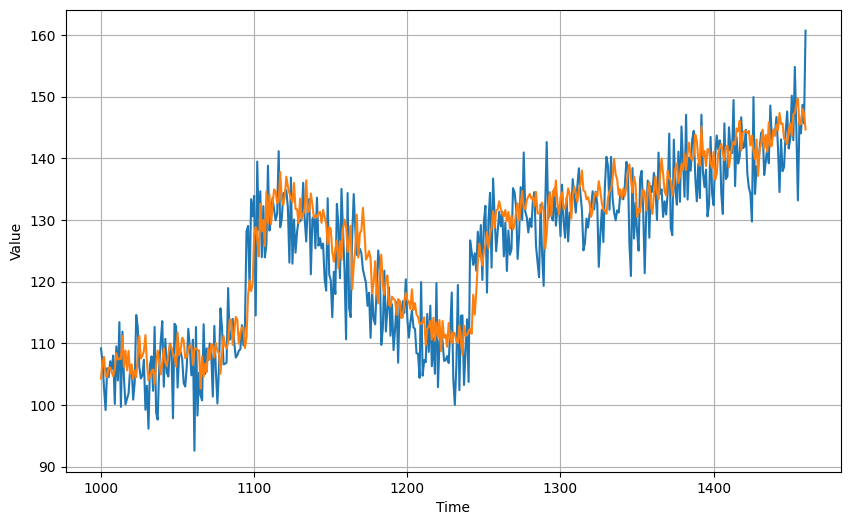

In [139]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    if label:
        plt.legend()

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, results)

**COMMENT** - The prediction isn’t bad. It’s generally **following the curve of the original data**. When there are rapid changes in the data, the prediction takes a little time to catch up, but on the whole it isn’t bad.

However, it’s **hard** to be precise when eyeballing the curve. It’s best to have a good metric $\rightarrow$ use the **MAE**.

In [140]:
# Create metric objects
mae_metric = tf.keras.metrics.MeanAbsoluteError()

# Update state with actual and predicted values
mae_metric.update_state(series_valid, results)

# Get the result
mae = mae_metric.result().numpy()

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 5.0065293


**Get the predictions as accurate as possible** $\Leftrightarrow$ **Minimize that MAE**

There are some techniques including the changing of the **`window size`** and some basic **hyperparameter tuning** on the optimizer to improve how your neural network learns

### **Tuning the Learning Rate**

*What if we changed the learning rate? And how should we go about changing it? It would take a lot of experimentation to find the best rate.*

Use a **callback** to adjust the learning rate over time, plot the value of that parameter against the loss for the appropriate epoch, and from there determine the best learning rate to use.

To do this, create a **`tf.keras.callbacks.LearningRateScheduler`** and have it populate the **`lr`** parameter with the desired starting value:

In [141]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

In this case, start the learning rate at **1e–8** and then every epoch **increase it by a small amount**. By the time it’s completed one hundred epochs, the learning rate will be up to about **1e–3**

Then initialize the optimizer with the learning rate of **1e–8** and use this callback within the **`model.fit`** call

In [144]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

model.compile(loss="mse", optimizer=optimizer)

history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Used **`history=model.fit`** $\rightarrow$ the training history is stored including **the  loss** $\rightarrow$ plot this against the learning rate per epoch

(1e-08, 0.001, 0.0, 300.0)

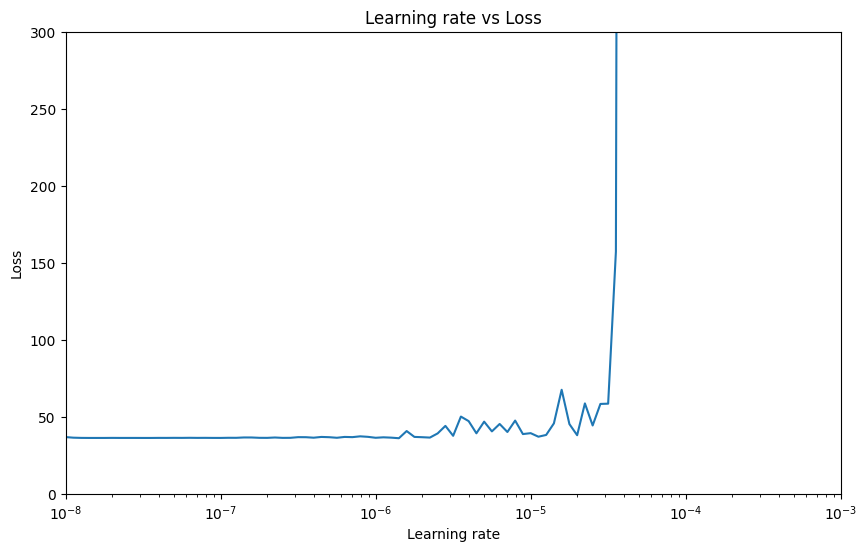

In [146]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.figure(figsize=(10, 6))
plt.semilogx(lrs, history.history["loss"])
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Learning rate vs Loss")
plt.axis([1e-8, 1e-3, 0, 300])

(1e-07, 1e-05, 0.0, 300.0)

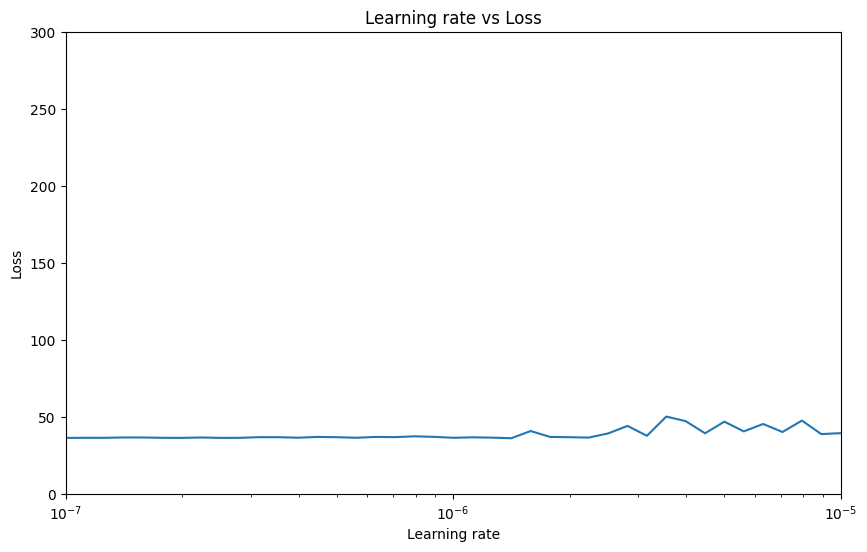

In [148]:
plt.figure(figsize=(10, 6))
plt.semilogx(lrs, history.history["loss"])
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Learning rate vs Loss")
plt.axis([1e-7, 1e-5, 0, 300])

Sets the **`lrs`** value using **the same formula as the lambda function**, and plots this against loss between **1e–8** and **1e–3**.

Set the learning rate to **1e–6**, has a smaller loss $\rightarrow$ go back to the model and redefine it with **1e–6** as the new learning rate.

After training the model, the **loss** has **reduced a bit** and when measured the MAE it also ended up as lower $\rightarrow$ taken a small step backward! 

### **Exploring Hyperparameter Tuning with Keras Tuner**

Changing the learning rate every few epochs and measuring the loss. It also was some what tainted by the fact that the loss function was already changing epoch to epoch $\rightarrow$ may NOT have actually been finding the best value **but an approximation**. 

To really **find the best value** $\rightarrow$ have to **train for the full set of epochs with each potential value** and then compare the results. 

And that’s just for one hyperparameter - the learning rate. 

If want to **find the best momentum** or **tune other things** like the model architecture — how many neurons per layer, how many layers, etc $\rightarrow$ end up with **many thousands of options to test**, and training across all of these would be **hard to code**.

$\Rightarrow$ The **Keras Tuner tool** makes this relatively *easy*

In [151]:
!pip install keras-tuner

Use it to **parameterize the hyperparameters** $\rightarrow$ specify ranges of values to test. 

Keras Tuner will **train multiple models**, one with **each possible set of parameters** $\rightarrow$ evaluate the model to a metric $\rightarrow$ report on the top models. 


Say experiment with **just two things**, the first being the number of **input neurons** in the model architecture. Now, a model architecture of **10 input neurons**, followed by **a hidden layer of 10**, followed by **the output layer**. 

*But could the network do better with more? What if experiment with up to 30 neurons in the input layer, for example?*

The **input layer** was defined -

```Python

tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),

```

To **test different values** than the hardcoded **10** $\rightarrow$ set it to cycle through a number of integers

In [175]:
hp = HyperParameters()

tf.keras.layers.Dense(units=hp.Int(name='units', min_value=10, max_value=30, step=2), activation='relu', input_shape=[window_size])

<Dense name=dense_3, built=False>

Define that the layer will be **tested** with **several input values**, **starting with 10** and **increasing to 30** in **steps of 2** $\rightarrow$ instead of training the model **just once** and seeing the loss, **`Keras Tuner`** will train the model **11 times**!

Also, when **compiled the model** $\rightarrow$ hardcoded **the value of the momentum parameter to be 0.9** -

```Python

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)


```

Change this to **cycle** through **a few options** instead by using the **`hp.Choice`** construct.

In [176]:
optimizer = tf.keras.optimizers.SGD(
        momentum=hp.Choice('momentum', values=[0.9, 0.7, 0.5, 0.3]), 
        learning_rate=1e-5
    )

Provide **four possible choices** $\rightarrow$ when combined with the model architecture defined previously $\rightarrow$ end up cycling through **44 possible combinations**. 

Keras Tuner can do this and **report back on the model that performed the best**. 

First create a function that builds the model.

In [182]:
def build_model(hp):
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Dense(
        units=hp.Int('units', min_value=10, max_value=30, step=2), 
        activation='relu', input_shape=[window_size]
    ))
    
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    
    model.compile(
        loss="mse", 
        optimizer=tf.keras.optimizers.SGD(
            momentum=hp.Choice('momentum', values=[0.9, 0.7, 0.5, 0.3]), 
            learning_rate=1e-5
        )
    )
    
    return model


Create a **`RandomSearch`** object that manages all the iterations for this model

In [183]:
tuner = RandomSearch(hypermodel=build_model, # function to build the model
                    objective='loss', # metric to minimize
                    max_trials=150, # number of hyperparameter combinations that will be tested by the tuner
                    executions_per_trial=3, # number of models to train per trial
                    directory='my_dir',  # where the logs and checkpoints will be saved
                    project_name='hello' # name of the project
                    )

c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**NOTE** 

1 _ Define the model by passing it the **build_model** function and the **hyperparameter parameter (hp)** is used to control which values get changed. 

2 _ Specify **the objective** to be **loss**, indicating that **minimize the loss**. 

3 _ Cap **the overall number of trials** to run with the **`max_trials`** parameter and specify **how many times to train** and **evaluate the model with the `executions_per_trial`** parameter.

To start the search $\rightarrow$ Call **`tuner.search`**

In [184]:
tuner.search(dataset, epochs=100, verbose=0)

c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


When it’s complete $\rightarrow$ call **`tuner.results_summary`** and the model will give **the top 10 trials based on the objective**:

In [185]:
tuner.results_summary()

Results summary
Results in my_dir\hello
Showing 10 best trials
Objective(name="loss", direction="min")

Trial 003 summary
Hyperparameters:
units: 16
momentum: 0.9
Score: 31.427616755167644

Trial 010 summary
Hyperparameters:
units: 24
momentum: 0.9
Score: 32.38212331136068

Trial 030 summary
Hyperparameters:
units: 20
momentum: 0.9
Score: 32.44050979614258

Trial 007 summary
Hyperparameters:
units: 28
momentum: 0.9
Score: 32.47057660420736

Trial 019 summary
Hyperparameters:
units: 18
momentum: 0.7
Score: 32.55533663431803

Trial 004 summary
Hyperparameters:
units: 22
momentum: 0.7
Score: 32.600165049235024

Trial 017 summary
Hyperparameters:
units: 26
momentum: 0.9
Score: 32.61358133951823

Trial 025 summary
Hyperparameters:
units: 22
momentum: 0.5
Score: 32.64713795979818

Trial 008 summary
Hyperparameters:
units: 22
momentum: 0.9
Score: 32.70225397745768

Trial 009 summary
Hyperparameters:
units: 30
momentum: 0.9
Score: 32.78304672241211


From the results, **the best loss score** was achieved with **a momentum of 0.9** and **16 input units**. 

Retrieve this model and other top models by calling **`get_best_models`** and specifying **how many the model want to retrieve**.

In [189]:
tuner.get_best_models(num_models=4)

[<Sequential name=sequential, built=True>,
 <Sequential name=sequential, built=True>,
 <Sequential name=sequential, built=True>,
 <Sequential name=sequential, built=True>]

Alternatively, **create a new model from scratch using the learned hyperparameters**

In [205]:
dataset = windowed_dataset(series_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
    ])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)

history = model.fit(dataset, epochs=100,  verbose=1)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 466.9437
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 69.0630  
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 49.8147 
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 47.4026 
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 49.4574 
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 46.4091
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 46.3436
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 49.8934
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 47.9849
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 44.1912
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 43.0200
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 44.4838 
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 41.8382 
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 46.1985 
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━

In [206]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

In [207]:
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

In [208]:
len(forecast)

461

In [209]:
results.shape

(461,)

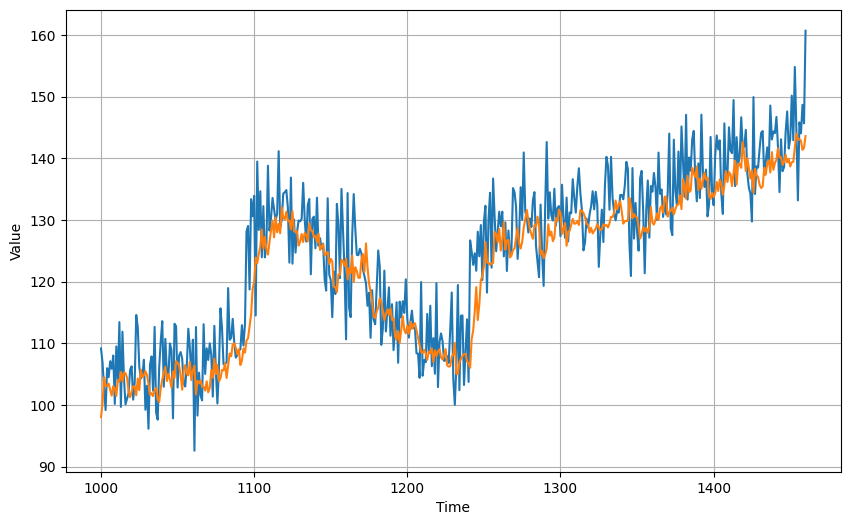

In [210]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    if label:
        plt.legend()

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, results)

In [211]:
# Create metric objects
mae_metric = tf.keras.metrics.MeanAbsoluteError()

# Update state with actual and predicted values
mae_metric.update_state(series_valid, results)

# Get the result
mae = mae_metric.result().numpy()

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 4.8929
